In [39]:
# ==============================
# 04_baseline_models.ipynb
# ==============================

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, precision_score, recall_score
from health_indicator_design import * 

In [16]:
data = pd.read_csv(r"D:\projects\aviation\dataset\engine_health_features.csv")
train = pd.read_csv(r"D:\projects\aviation\dataset\clean_train_data.csv")

X = data.drop(columns=["id", "cycle", "RUL"])
y_rul = data["RUL"]
data.head()


,id,cycle,RUL,health_score,s11_roll_mean,s11_roll_std,s4_roll_mean,s4_roll_std,s15_roll_mean,s15_roll_std,...,s13_roll_mean,s13_roll_std,s11_slope,s4_slope,s15_slope,s2_slope,s17_slope,s3_slope,s8_slope,s13_slope
0,1,1,191,93.009519,47.470,NaN,1400.600000,NaN,8.419500,NaN,...,2388.020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,190,94.770763,47.480,0.014142,1401.870000,1.796051,8.425650,0.008697,...,2388.045,0.035355,0.020,2.540,0.01230,0.330,-1.136868e-13,2.120,-0.020,0.050
2,1,3,189,92.444708,47.410,0.121655,1402.646667,1.850009,8.423033,0.007640,...,2388.040,0.026458,-0.100,1.800,-0.00085,0.265,-1.000000e+00,-0.855,0.010,0.005
3,1,4,188,91.542233,47.340,0.171659,1402.452500,1.559645,8.409325,0.028117,...,2388.050,0.029439,-0.124,0.487,-0.01679,0.179,-2.000000e-01,-2.456,0.019,0.014
4,1,5,187,94.250895,47.328,0.151063,1403.206000,2.159440,8.413340,0.025953,...,2388.048,0.025884,-0.074,0.997,-0.00438,0.130,2.000000e-01,-2.273,0.007,0.005


In [17]:
X = X.groupby(data["id"]).ffill().fillna(0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_rul, test_size=0.2, random_state=42
)

lr = LinearRegression()
lr.fit(X_train, y_train)

pred = lr.predict(X_test)
mae = mean_absolute_error(y_test, pred)
mae


32.160898356379725

In [18]:
data["fail_30"] = (data["RUL"] <= 30).astype(int)

X = data.drop(columns=["id", "cycle", "RUL", "fail_30"])
y = data["fail_30"]

X = X.groupby(data["id"]).ffill().fillna(0)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

precision, recall


c:\Users\osawa\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.8964879852125693, 0.8304794520547946)

In [19]:
alerts = data[data["fail_30"] == 1]

lead_time = alerts.groupby("id")["RUL"].max().mean()
lead_time


30.0

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

engine_id = 1
sensor = "s9"

df_e = train[train["id"] == engine_id].sort_values("cycle")
series = df_e[sensor].values


In [22]:
from statsmodels.tsa.stattools import adfuller

adf_stat, p_value, *_ = adfuller(series)
print("ADF p-value:", p_value)


ADF p-value: 0.9810672510907934


In [23]:
series_diff = df_e[sensor].diff().dropna()


In [24]:
from statsmodels.tsa.stattools import adfuller

adf_stat, p_value, *_ = adfuller(series_diff)
print("ADF p-value after differencing:", p_value)


ADF p-value after differencing: 9.618940311737783e-09


In [25]:
from statsmodels.tsa.arima.model import ARIMA

for p,q,r in [(1,0,0), (0,1,0), (0,0,1), (1,1,1)]:
    model = ARIMA(series, order=(p,q,r))
    model_fit = model.fit()
    print(f"ARIMA({p},{q},{r}) AIC: {model_fit.aic}")


print(model_fit.summary())


ARIMA(1,0,0) AIC: 1150.9856341107488
ARIMA(0,1,0) AIC: 1230.509533897311
ARIMA(0,0,1) AIC: 1153.484128275873
ARIMA(1,1,1) AIC: 1118.893024035303
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  192
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -556.447
Date:                Mon, 12 Jan 2026   AIC                           1118.893
Time:                        17:19:42   BIC                           1128.650
Sample:                             0   HQIC                          1122.845
                                - 192                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0176      0.082     -0.214      0.830      -0.17

In [30]:
# For regression
y_rul = train["RUL"]

X_train_rul, X_test_rul, y_train_rul, y_test_rul = train_test_split(
    X, y_rul, test_size=0.2, random_state=42
)


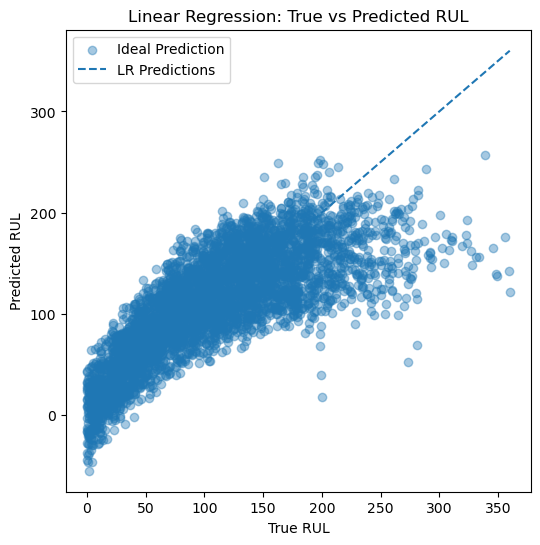

In [32]:
y_pred_lr = lr.predict(X_test_rul)

plt.figure(figsize=(6,6))
plt.scatter(y_test_rul, y_pred_lr, alpha=0.4)
plt.plot(
    [y_test_rul.min(), y_test_rul.max()],
    [y_test_rul.min(), y_test_rul.max()],
    linestyle="--"
)

plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Linear Regression: True vs Predicted RUL")
plt.legend(["Ideal Prediction", "LR Predictions"])
plt.show()


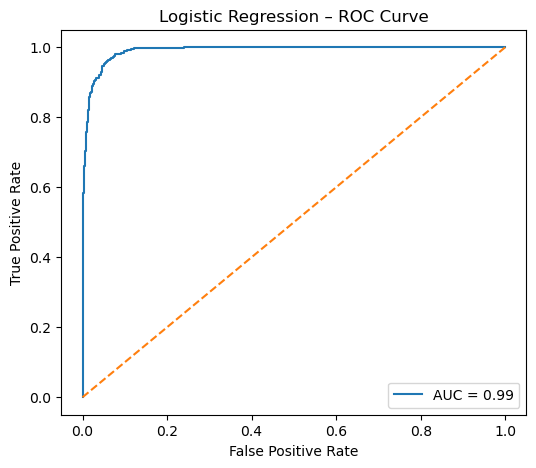

In [27]:
from sklearn.metrics import roc_curve, auc

y_prob = clf.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression – ROC Curve")
plt.legend()
plt.show()


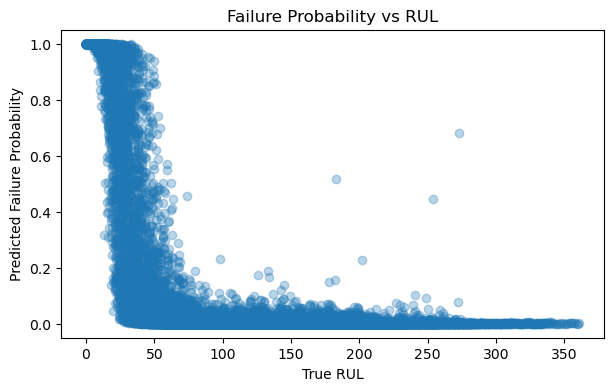

In [28]:
plt.figure(figsize=(7,4))
plt.scatter(y_rul, clf.predict_proba(X)[:,1], alpha=0.3)
plt.xlabel("True RUL")
plt.ylabel("Predicted Failure Probability")
plt.title("Failure Probability vs RUL")
plt.show()


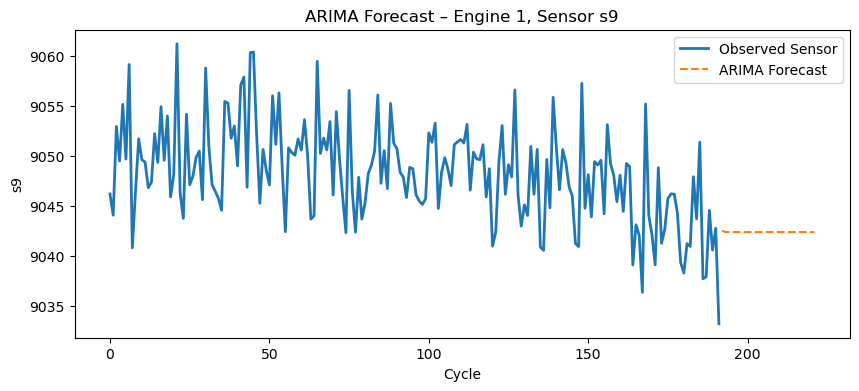

In [ ]:
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)

plt.figure(figsize=(10,4))
plt.plot(series, label="Observed Sensor", linewidth=2)
plt.plot(
    range(len(series), len(series)+forecast_steps),
    forecast,
    linestyle="--",
    label="ARIMA Forecast"
)

plt.xlabel("Cycle")
plt.ylabel(sensor)
plt.title(f"ARIMA Forecast – Engine {engine_id}, Sensor {sensor}")
plt.legend()
plt.show()
